In [ ]:
# ============================================================================
# CELL 1: INSTALLATIONS
# ============================================================================
print("Installing required packages...")

# Install XGBoost (usually pre-installed, but ensuring latest version)
!pip install -q xgboost

# Install LightGBM
!pip install -q lightgbm

# Install plotting libraries (if not already available)
!pip install -q matplotlib seaborn

print("All packages installed successfully!")

Installing required packages...
All packages installed successfully!


In [ ]:
# ============================================================================
# CELL 2: IMPORTS
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Import the modules themselves for version checking
import xgboost
import lightgbm

# Import the classifier classes
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All imports successful!")
print(f"XGBoost version: {xgboost.__version__}")
print(f"LightGBM version: {lightgbm.__version__}")

All imports successful!
XGBoost version: 3.0.5
LightGBM version: 4.6.0


In [ ]:
# ============================================================================
# CELL 3: DEFINE FEATURE SETS (CORRECTED)
# ============================================================================

backbone_features = [
    'trigram_diversity',
    'yules_k',
    'comma_ratio',
    'colon_ratio',
    'pos_ratio_NUM',
    'verbs_per_100_tok',
    'sentence_length_std',
    'n_sentences_doc',
    'exclamation_ratio',
    'token_burstiness'
]

# Original expected_features with 9 features removed that don't exist
expected_features = [
    # 'smog_index', 'automated_readability_index',  # REMOVED - not in df
    # 'unigram_diversity',  # REMOVED - not in df
    'trigram_diversity',
    # 'hapax_type_ratio',  # REMOVED - not in df
    'yules_k',
    # 'mtld',  # REMOVED - not in df
    # 'trigram_entropy',  # REMOVED - not in df
    'token_burstiness', 'char_trigram_entropy',
    'avg_tree_depth', 'max_tree_depth', 'avg_dependency_distance',
    # 'right_dependency_ratio',  # REMOVED - not in df
    'uppercase_ratio', 'whitespace_ratio', 'unique_char_count',
    # 'bits_per_char',  # REMOVED - not in df
    'comma_ratio', 'period_ratio', 'question_ratio', 'exclamation_ratio',
    'semicolon_ratio', 'colon_ratio', 'quote_ratio',
    'sentiment_polarity', 'sentiment_subjectivity', 'sentiment_polarity_variance',
    'neutral_sentence_ratio', 'positive_word_ratio', 'negative_word_ratio',
    'pos_ratio_DET', 'pos_ratio_ADP', 'pos_ratio_AUX', 'pos_ratio_CCONJ',
    'pos_ratio_PART', 'pos_ratio_NUM', 'pos_row_entropy_weighted',
    'function_to_content_rate', 'noun_verb_alternation_rate', 'content_function_ratio',
    'noun_verb_ratio', 'adj_adv_ratio', 'verbs_per_100_tok', 'nouns_per_100_tok',
    'adj_per_100_tok', 'adv_per_100_tok', 'pron_per_100_tok', 'punct_per_100_tok',
    'tokens_per_sentence_mean', 'mean_nouns_per_sent', 'mean_verbs_per_sent',
    'mean_adjs_per_sent', 'mean_advs_per_sent', 'prop_sents_with_verb',
    'unique_upos_per_sent_mean', 'max_runlen_NOUN', 'max_runlen_PUNCT',
    'avg_sentence_length', 'sentence_length_std',
    # 'n_tokens_doc',  # REMOVED - not in df
    'n_sentences_doc'
]

# Verify all backbone features exist in expected_features
missing = set(backbone_features) - set(expected_features)
if missing:
    print(f"WARNING: {missing} not in full feature set")
else:
    print(f"✓ All {len(backbone_features)} backbone features found in full feature set")
    print(f"✓ Full feature set contains {len(expected_features)} features")
    print(f"\nFeature sets defined:")
    print(f"  - Backbone: 10 features (84.8% reduction)")
    print(f"  - Full: 53 features")

✓ All 10 backbone features found in full feature set
✓ Full feature set contains 53 features

Feature sets defined:
  - Backbone: 10 features (84.8% reduction)
  - Full: 53 features


In [ ]:
# ============================================================================
# CELL 4: LOAD YOUR DATA
# ============================================================================

# Replace this with your actual data loading
# Example:
df = pd.read_csv(r'/content/raid_sample_large_PostPOS_CLEAN.csv')
# OR if you're loading from previous notebook variables:
# Assuming df already exists with your features and 'is_ai' column

# Verify data
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['is_ai'].value_counts()}")
print(f"\nFeature columns available: {len(df.columns)}")

# Check for missing values
missing_counts = df[expected_features].isnull().sum()
if missing_counts.sum() > 0:
    print(f"\nWARNING: Missing values detected:")
    print(missing_counts[missing_counts > 0])
else:
    print("\n✓ No missing values in feature set")

# Prepare data matrices
X_backbone = df[backbone_features].values
X_full = df[expected_features].values
y = df['is_ai'].values  # CHANGED FROM 'label' to 'is_ai'

print(f"\nData prepared:")
print(f"  Backbone features: {X_backbone.shape}")
print(f"  Full features: {X_full.shape}")
print(f"  Labels: {y.shape}")
print(f"  Class distribution: AI={y.sum()}, Human={len(y)-y.sum()}")

Dataset shape: (60000, 86)
Class distribution:
is_ai
True     30000
False    30000
Name: count, dtype: int64

Feature columns available: 86

✓ No missing values in feature set

Data prepared:
  Backbone features: (60000, 10)
  Full features: (60000, 53)
  Labels: (60000,)
  Class distribution: AI=30000, Human=30000


In [ ]:
# ============================================================================
# CELL 5: DEFINE MODEL POOL
# ============================================================================

def get_model_pool():
    """
    Returns dictionary of models to test
    """
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            random_state=42,
            n_jobs=-1
        ),

        'XGBoost': XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss',
            verbosity=0
        ),

        'LightGBM': LGBMClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),

        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=42,
            C=1.0,
            solver='lbfgs'
        ),

        'SVM (RBF)': SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            probability=True,
            random_state=42
        ),

        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=42
        )
    }

    return models

models = get_model_pool()
print(f"Model pool initialized with {len(models)} models:")
for model_name in models.keys():
    print(f"  - {model_name}")

Model pool initialized with 6 models:
  - Random Forest
  - XGBoost
  - LightGBM
  - Logistic Regression
  - SVM (RBF)
  - Gradient Boosting


In [ ]:
# ============================================================================
# CELL 6: LEARNING CURVE ANALYSIS FUNCTION (IMPROVED VISUALIZATION)
# ============================================================================

def plot_learning_curve(model, X, y, model_name, cv=5):
    """
    Creates learning curve showing performance vs training size
    Implements your professor's suggestion of testing every 2000 samples
    """
    # Calculate max available training samples with CV
    # With 5-fold CV, each fold uses 80% for training
    max_train_samples = int(len(X) * (cv - 1) / cv)

    # Define training sizes: every 2000 samples up to max available
    train_sizes = np.arange(2000, max_train_samples + 1, 2000)

    # Make sure we don't exceed the limit
    train_sizes = train_sizes[train_sizes <= max_train_samples]

    print(f"\nGenerating learning curve for {model_name}...")
    print(f"Total samples: {len(X)}, Max training per fold: {max_train_samples}")
    print(f"Testing {len(train_sizes)} different training sizes: {train_sizes.tolist()}")

    # Calculate learning curve with CV at each size
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        train_sizes=train_sizes,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot training and validation curves
    ax.plot(train_sizes_abs, train_mean, 'o-', color='#2E86AB',
            label='Training score', linewidth=2.5, markersize=8)
    ax.plot(train_sizes_abs, val_mean, 'o-', color='#A23B72',
            label='Validation score', linewidth=2.5, markersize=8)

    # Fill between for confidence intervals
    ax.fill_between(train_sizes_abs,
                     train_mean - train_std,
                     train_mean + train_std,
                     alpha=0.15, color='#2E86AB')
    ax.fill_between(train_sizes_abs,
                     val_mean - val_std,
                     val_mean + val_std,
                     alpha=0.15, color='#A23B72')

    # Enhanced plateau detection with broader threshold
    if len(val_mean) >= 3:
        # Calculate moving average of improvements
        improvements = np.diff(val_mean)

        # Detect plateau: if last 2-3 improvements are small
        plateau_threshold = 0.01  # 1% improvement threshold (broader)

        plateau_detected = False
        plateau_idx = None

        # Check if we've plateaued (last 2 improvements < threshold)
        if len(improvements) >= 2:
            if np.all(improvements[-2:] < plateau_threshold):
                plateau_idx = len(val_mean) - 2
                plateau_detected = True

        if plateau_detected:
            # Draw plateau region (shaded area)
            plateau_start = train_sizes_abs[plateau_idx]
            ax.axvspan(plateau_start, train_sizes_abs[-1],
                      alpha=0.2, color='orange',
                      label=f'Plateau region (improvement < {plateau_threshold:.1%})')

            # Add vertical line at plateau start
            ax.axvline(plateau_start, color='red',
                      linestyle='--', linewidth=2, alpha=0.7)

            # Add annotation
            mid_plateau = (plateau_start + train_sizes_abs[-1]) / 2
            ax.annotate('Performance plateau',
                       xy=(mid_plateau, val_mean[-1]),
                       xytext=(mid_plateau, val_mean[-1] - 0.1),
                       ha='center',
                       fontsize=11,
                       bbox=dict(boxstyle='round,pad=0.5',
                                facecolor='orange', alpha=0.3),
                       arrowprops=dict(arrowstyle='->',
                                     connectionstyle='arc3,rad=0',
                                     color='red', lw=2))

    # Formatting
    ax.set_xlabel('Training Set Size', fontsize=13, fontweight='bold')
    ax.set_ylabel('F1 Score', fontsize=13, fontweight='bold')
    ax.set_title(f'Learning Curve: {model_name}', fontsize=15, fontweight='bold')
    ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')

    # Start Y-axis from 0 for full perspective
    ax.set_ylim([0.0, 1.0])

    # Add horizontal reference lines
    ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    ax.axhline(y=0.7, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.3, linewidth=1)

    # Set X-axis to start from 0 for visual clarity
    ax.set_xlim([0, train_sizes_abs[-1] * 1.05])

    plt.tight_layout()
    plt.show()

    # Print numerical results
    print(f"\nPerformance at different training sizes:")
    print(f"{'Size':>8} | {'Train F1':>10} | {'Val F1':>10} | {'Improvement':>12} | {'% Change':>10}")
    print("-" * 65)
    for i, (size, train_f1, val_f1) in enumerate(zip(train_sizes_abs, train_mean, val_mean)):
        improvement = val_f1 - val_mean[i-1] if i > 0 else 0
        pct_change = (improvement / val_mean[i-1] * 100) if i > 0 else 0
        print(f"{size:>8} | {train_f1:>10.4f} | {val_f1:>10.4f} | {improvement:>+12.4f} | {pct_change:>+9.2f}%")

    # Enhanced final assessment
    print("\n" + "="*65)
    if len(val_mean) >= 2:
        final_improvement = val_mean[-1] - val_mean[-2]
        total_improvement = val_mean[-1] - val_mean[0]
        pct_final = (final_improvement / val_mean[-2] * 100)

        print(f"PLATEAU ANALYSIS:")
        print(f"  Final improvement (last step): {final_improvement:+.4f} ({pct_final:+.2f}%)")
        print(f"  Total improvement: {total_improvement:+.4f}")
        print(f"  Peak F1 score: {val_mean.max():.4f} at {train_sizes_abs[val_mean.argmax()]} samples")

        if final_improvement < 0.01:
            print(f"\n✓ PLATEAU REACHED: Additional data unlikely to help significantly")
            print(f"  Recommendation: {train_sizes_abs[plateau_idx if plateau_idx else -2]} samples sufficient")
        elif final_improvement < 0.02:
            print(f"\n⚠ MARGINAL IMPROVEMENT: Approaching plateau")
            print(f"  Recommendation: Modest additional data may help slightly")
        else:
            print(f"\n⚠ STILL IMPROVING: More data would likely improve performance")
            print(f"  Recommendation: Collect more data if possible")

    # Important note about dataset size
    print(f"\nDATASET CONTEXT:")
    print(f"  Total samples: {len(X)}")
    print(f"  Max training size (with {cv}-fold CV): {max_train_samples}")
    print(f"  Tested up to: {train_sizes_abs[-1]} samples ({train_sizes_abs[-1]/max_train_samples*100:.1f}% of max)")

    return train_sizes_abs, train_mean, val_mean, train_std, val_std

In [ ]:
# ============================================================================
# CELL 7: K-FOLD CROSS-VALIDATION COMPARISON FUNCTION
# ============================================================================

def compare_models_kfold(models, X, y, feature_set_name, n_splits=5):
    """
    Compare multiple models using stratified k-fold cross-validation
    Uses all available data to find the best model
    """
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_results = []

    print(f"\n{'='*70}")
    print(f"K-FOLD CROSS-VALIDATION: {feature_set_name}")
    print(f"{'='*70}")
    print(f"Using {n_splits}-fold stratified CV on {len(X)} samples\n")

    for model_name, model in models.items():
        print(f"\n{model_name}:")
        print("-" * 40)

        fold_results = []

        for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Train
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val)[:, 1]

            # Calculate metrics
            acc = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_proba)

            fold_results.append({
                'model': model_name,
                'feature_set': feature_set_name,
                'fold': fold_idx + 1,
                'accuracy': acc,
                'f1': f1,
                'roc_auc': auc
            })

            print(f"  Fold {fold_idx + 1}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

        all_results.extend(fold_results)

        # Print summary for this model
        fold_df = pd.DataFrame(fold_results)
        print(f"  Mean:   Acc={fold_df['accuracy'].mean():.4f}, "
              f"F1={fold_df['f1'].mean():.4f}, AUC={fold_df['roc_auc'].mean():.4f}")
        print(f"  Std:    Acc={fold_df['accuracy'].std():.4f}, "
              f"F1={fold_df['f1'].std():.4f}, AUC={fold_df['roc_auc'].std():.4f}")

    return pd.DataFrame(all_results)


def visualize_model_comparison(results_df):
    """
    Create visualization comparing models
    """
    # Aggregate results
    summary = results_df.groupby(['model', 'feature_set']).agg({
        'accuracy': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'roc_auc': ['mean', 'std']
    }).reset_index()

    # Flatten column names
    summary.columns = ['model', 'feature_set', 'acc_mean', 'acc_std',
                       'f1_mean', 'f1_std', 'auc_mean', 'auc_std']

    # Create comparison plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    metrics = [('acc_mean', 'acc_std', 'Accuracy'),
               ('f1_mean', 'f1_std', 'F1 Score'),
               ('auc_mean', 'auc_std', 'ROC-AUC')]

    for ax, (mean_col, std_col, title) in zip(axes, metrics):
        for feature_set in summary['feature_set'].unique():
            data = summary[summary['feature_set'] == feature_set]
            x = np.arange(len(data))
            ax.bar(x, data[mean_col], yerr=data[std_col],
                   label=feature_set, alpha=0.7, capsize=5)
            x = x + 0.35

        ax.set_xlabel('Model', fontsize=11)
        ax.set_ylabel(title, fontsize=11)
        ax.set_title(f'{title} by Model', fontsize=12, fontweight='bold')
        ax.set_xticks(np.arange(len(data)) + 0.175)
        ax.set_xticklabels(data['model'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0.5, 1.0])

    plt.tight_layout()
    plt.show()

    return summary


######################################################################
# PART 1: LEARNING CURVE ANALYSIS
# (Answers: Do we need more data? When does performance plateau?)
######################################################################

Generating learning curve for Random Forest...
Total samples: 60000, Max training per fold: 48000
Testing 24 different training sizes: [2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000, 40000, 42000, 44000, 46000, 48000]


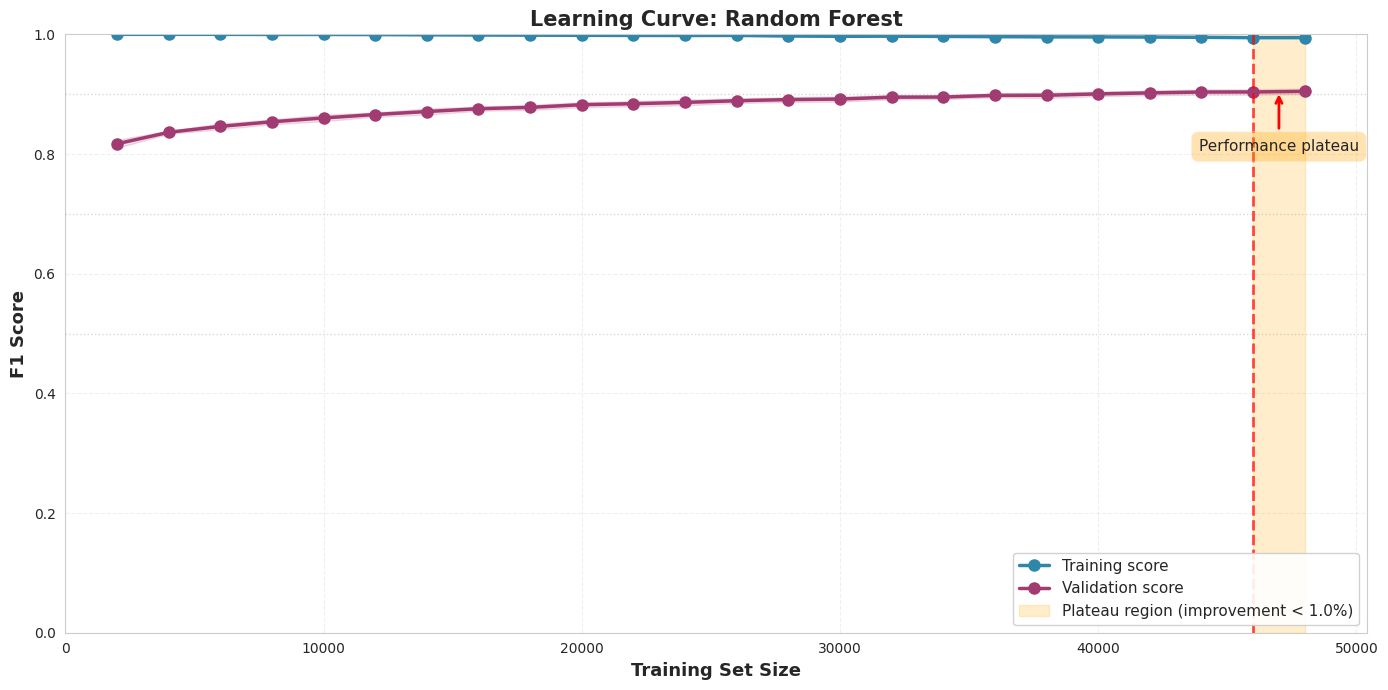


Performance at different training sizes:
    Size |   Train F1 |     Val F1 |  Improvement |   % Change
-----------------------------------------------------------------
    2000 |     1.0000 |     0.8170 |      +0.0000 |     +0.00%
    4000 |     1.0000 |     0.8362 |      +0.0192 |     +2.35%
    6000 |     1.0000 |     0.8462 |      +0.0100 |     +1.19%
    8000 |     0.9998 |     0.8538 |      +0.0077 |     +0.91%
   10000 |     0.9998 |     0.8602 |      +0.0064 |     +0.75%
   12000 |     0.9996 |     0.8660 |      +0.0058 |     +0.67%
   14000 |     0.9992 |     0.8710 |      +0.0050 |     +0.57%
   16000 |     0.9989 |     0.8757 |      +0.0047 |     +0.55%
   18000 |     0.9986 |     0.8779 |      +0.0022 |     +0.25%
   20000 |     0.9984 |     0.8824 |      +0.0045 |     +0.51%
   22000 |     0.9982 |     0.8841 |      +0.0017 |     +0.19%
   24000 |     0.9981 |     0.8862 |      +0.0021 |     +0.24%
   26000 |     0.9982 |     0.8890 |      +0.0028 |     +0.32%
   28000 |

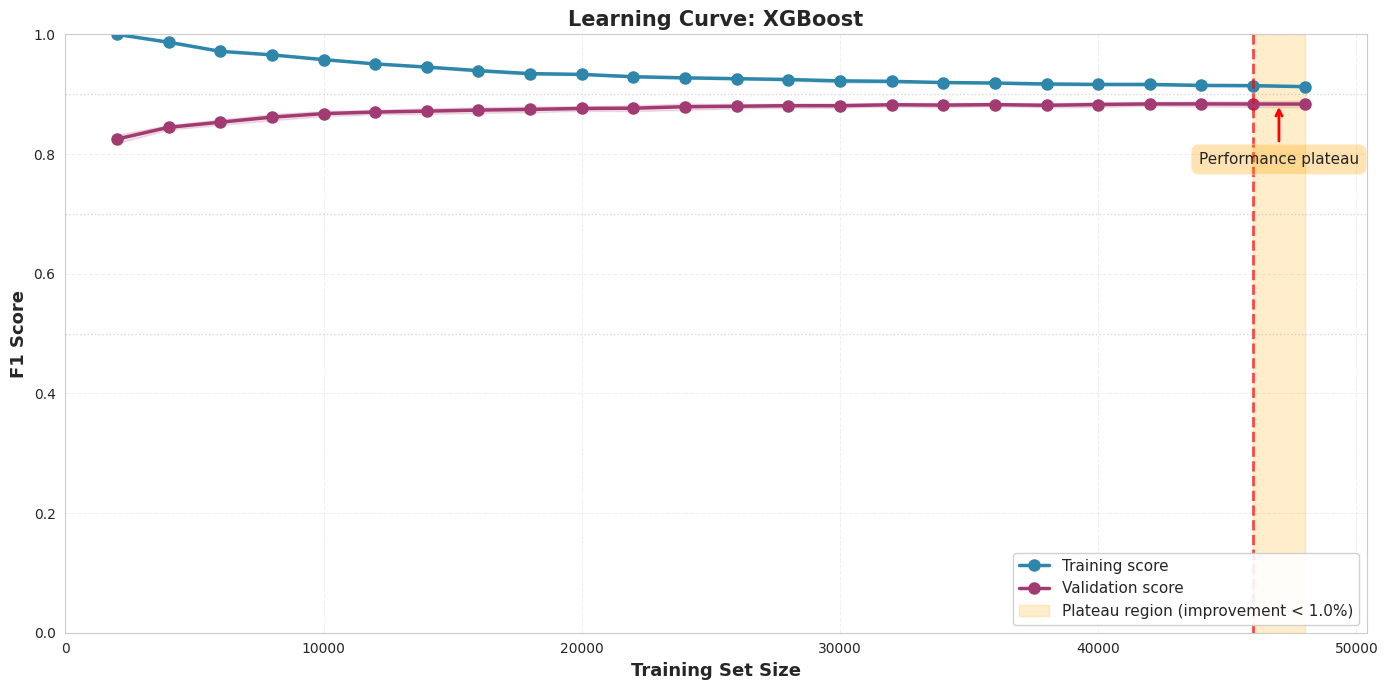


Performance at different training sizes:
    Size |   Train F1 |     Val F1 |  Improvement |   % Change
-----------------------------------------------------------------
    2000 |     0.9999 |     0.8250 |      +0.0000 |     +0.00%
    4000 |     0.9869 |     0.8446 |      +0.0196 |     +2.38%
    6000 |     0.9716 |     0.8532 |      +0.0086 |     +1.01%
    8000 |     0.9657 |     0.8616 |      +0.0084 |     +0.99%
   10000 |     0.9577 |     0.8675 |      +0.0058 |     +0.68%
   12000 |     0.9506 |     0.8701 |      +0.0027 |     +0.31%
   14000 |     0.9453 |     0.8717 |      +0.0015 |     +0.18%
   16000 |     0.9393 |     0.8734 |      +0.0017 |     +0.20%
   18000 |     0.9343 |     0.8746 |      +0.0012 |     +0.13%
   20000 |     0.9331 |     0.8761 |      +0.0015 |     +0.18%
   22000 |     0.9292 |     0.8765 |      +0.0004 |     +0.05%
   24000 |     0.9273 |     0.8790 |      +0.0025 |     +0.28%
   26000 |     0.9259 |     0.8798 |      +0.0008 |     +0.09%
   28000 |

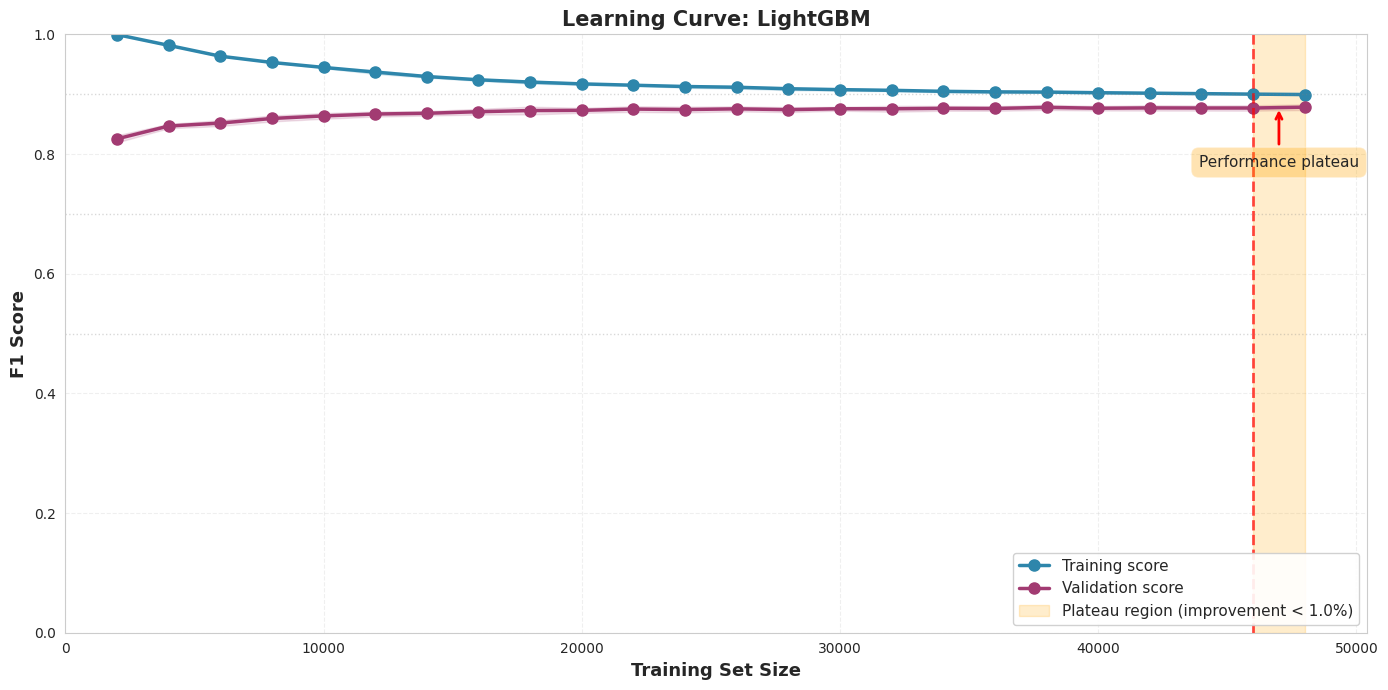


Performance at different training sizes:
    Size |   Train F1 |     Val F1 |  Improvement |   % Change
-----------------------------------------------------------------
    2000 |     0.9996 |     0.8253 |      +0.0000 |     +0.00%
    4000 |     0.9816 |     0.8467 |      +0.0214 |     +2.60%
    6000 |     0.9635 |     0.8517 |      +0.0049 |     +0.58%
    8000 |     0.9530 |     0.8594 |      +0.0077 |     +0.91%
   10000 |     0.9447 |     0.8636 |      +0.0043 |     +0.50%
   12000 |     0.9369 |     0.8668 |      +0.0032 |     +0.37%
   14000 |     0.9295 |     0.8681 |      +0.0013 |     +0.15%
   16000 |     0.9241 |     0.8707 |      +0.0026 |     +0.30%
   18000 |     0.9202 |     0.8727 |      +0.0020 |     +0.23%
   20000 |     0.9172 |     0.8729 |      +0.0003 |     +0.03%
   22000 |     0.9150 |     0.8751 |      +0.0021 |     +0.25%
   24000 |     0.9128 |     0.8743 |      -0.0008 |     -0.09%
   26000 |     0.9116 |     0.8755 |      +0.0012 |     +0.13%
   28000 |

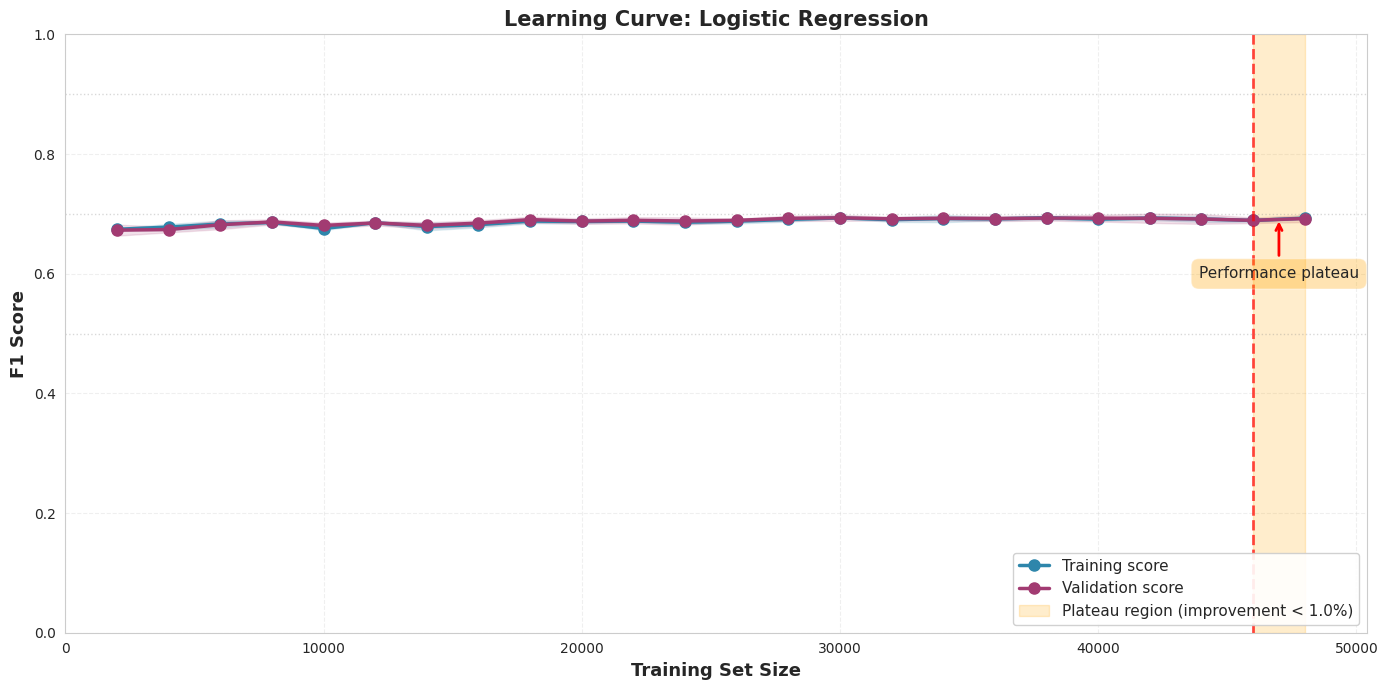


Performance at different training sizes:
    Size |   Train F1 |     Val F1 |  Improvement |   % Change
-----------------------------------------------------------------
    2000 |     0.6742 |     0.6727 |      +0.0000 |     +0.00%
    4000 |     0.6779 |     0.6738 |      +0.0010 |     +0.15%
    6000 |     0.6830 |     0.6818 |      +0.0080 |     +1.19%
    8000 |     0.6856 |     0.6865 |      +0.0048 |     +0.70%
   10000 |     0.6755 |     0.6807 |      -0.0059 |     -0.85%
   12000 |     0.6852 |     0.6848 |      +0.0041 |     +0.60%
   14000 |     0.6787 |     0.6808 |      -0.0040 |     -0.58%
   16000 |     0.6819 |     0.6845 |      +0.0037 |     +0.54%
   18000 |     0.6879 |     0.6904 |      +0.0059 |     +0.86%
   20000 |     0.6873 |     0.6879 |      -0.0025 |     -0.36%
   22000 |     0.6879 |     0.6893 |      +0.0014 |     +0.20%
   24000 |     0.6859 |     0.6881 |      -0.0012 |     -0.17%
   26000 |     0.6877 |     0.6892 |      +0.0011 |     +0.16%
   28000 |

In [ ]:
# ============================================================================
# CELL 8: RUN PART 1 - LEARNING CURVE ANALYSIS (FULL FEATURES ONLY)
# ============================================================================

print("\n" + "#"*70)
print("# PART 1: LEARNING CURVE ANALYSIS")
print("# (Answers: Do we need more data? When does performance plateau?)")
print("#"*70)

learning_curve_results = {}

# Test each model with FULL features only
for model_name, model in models.items():
    sizes, train_mean, val_mean, train_std, val_std = plot_learning_curve(
        model, X_full, y, model_name, cv=5  # Changed from X_backbone to X_full
    )

    learning_curve_results[model_name] = {
        'sizes': sizes,
        'train_mean': train_mean,
        'val_mean': val_mean,
        'train_std': train_std,
        'val_std': val_std
    }

In [ ]:
# ============================================================================
# CELL 9: COMPARE LEARNING CURVES ACROSS MODELS
# ============================================================================

print("\n" + "="*70)
print("LEARNING CURVE COMPARISON ACROSS ALL MODELS")
print("="*70)

# Plot all models on same graph for comparison
fig, ax = plt.subplots(figsize=(14, 7))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#BC4B51']

for (model_name, results), color in zip(learning_curve_results.items(), colors):
    ax.plot(results['sizes'], results['val_mean'], 'o-',
            label=model_name, linewidth=2, markersize=5, color=color)
    ax.fill_between(results['sizes'],
                     results['val_mean'] - results['val_std'],
                     results['val_mean'] + results['val_std'],
                     alpha=0.1, color=color)

ax.set_xlabel('Training Set Size', fontsize=12)
ax.set_ylabel('Validation F1 Score', fontsize=12)
ax.set_title('Learning Curves: All Models Comparison (Backbone Features)',
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

# Print final performance comparison
print("\nFinal Performance (at maximum training size):")
print(f"{'Model':<25} | {'F1 Score':>10} | {'Std Dev':>10}")
print("-" * 50)

final_performances = []
for model_name, results in learning_curve_results.items():
    final_f1 = results['val_mean'][-1]
    final_std = results['val_std'][-1]
    final_performances.append((model_name, final_f1, final_std))
    print(f"{model_name:<25} | {final_f1:>10.4f} | {final_std:>10.4f}")

# Identify best model
best_model_name = max(final_performances, key=lambda x: x[1])
print(f"\n✓ Best model: {best_model_name[0]} (F1 = {best_model_name[1]:.4f})")

In [ ]:
# ============================================================================
# CELL 10: RUN PART 2 - K-FOLD MODEL COMPARISON (FULL FEATURES ONLY)
# ============================================================================

print("\n\n" + "#"*70)
print("# PART 2: K-FOLD CROSS-VALIDATION MODEL COMPARISON")
print("# (Answers: Which model performs best using all data?)")
print("#"*70)

# Compare models with FULL features only
results_full = compare_models_kfold(
    models, X_full, y,
    feature_set_name='Full Stylometric Features (53 features)',
    n_splits=5
)

# Visualize comparison
print("\n\nGenerating comparison visualizations...")

# Since we only have one feature set, create simplified summary
summary = results_full.groupby('model').agg({
    'accuracy': ['mean', 'std'],
    'f1': ['mean', 'std'],
    'roc_auc': ['mean', 'std']
}).round(4)

summary.columns = ['acc_mean', 'acc_std', 'f1_mean', 'f1_std', 'auc_mean', 'auc_std']
summary = summary.reset_index()

print("\n" + "="*70)
print("SUMMARY TABLE: ALL MODELS WITH FULL FEATURES")
print("="*70)
print(summary.to_string(index=False))

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = [('acc_mean', 'acc_std', 'Accuracy'),
           ('f1_mean', 'f1_std', 'F1 Score'),
           ('auc_mean', 'auc_std', 'ROC-AUC')]

for ax, (mean_col, std_col, title) in zip(axes, metrics):
    x = np.arange(len(summary))
    bars = ax.bar(x, summary[mean_col], yerr=summary[std_col],
                  alpha=0.7, capsize=5, color='steelblue')

    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} Comparison (53 Features)', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(summary['model'], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# CELL 12: DETAILED ANALYSIS AND RECOMMENDATIONS (FULL FEATURES ONLY)
# ============================================================================

print("\n\n" + "#"*70)
print("# FINAL ANALYSIS AND RECOMMENDATIONS")
print("#"*70)

# Best model overall
best_model_row = summary.loc[summary['f1_mean'].idxmax()]
print(f"\n✓ BEST OVERALL PERFORMANCE:")
print(f"  Model: {best_model_row['model']}")
print(f"  F1 Score: {best_model_row['f1_mean']:.4f} ± {best_model_row['f1_std']:.4f}")
print(f"  Accuracy: {best_model_row['acc_mean']:.4f} ± {best_model_row['acc_std']:.4f}")
print(f"  ROC-AUC: {best_model_row['auc_mean']:.4f} ± {best_model_row['auc_std']:.4f}")

# Rank all models
print("\n\nMODEL RANKING (by F1 Score):")
ranked = summary.sort_values('f1_mean', ascending=False)
print(f"{'Rank':<6} | {'Model':<25} | {'F1 Score':>15}")
print("-" * 50)
for idx, (_, row) in enumerate(ranked.iterrows(), 1):
    print(f"{idx:<6} | {row['model']:<25} | {row['f1_mean']:.4f} ± {row['f1_std']:.4f}")

# Performance spread
f1_range = summary['f1_mean'].max() - summary['f1_mean'].min()
print(f"\n\nPERFORMANCE SPREAD:")
print(f"  Best F1: {summary['f1_mean'].max():.4f}")
print(f"  Worst F1: {summary['f1_mean'].min():.4f}")
print(f"  Range: {f1_range:.4f} ({f1_range/summary['f1_mean'].max()*100:.1f}%)")

# Statistical insights
print("\n\nKEY INSIGHTS:")

# 1. Model architecture patterns
tree_models = ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']
linear_models = ['Logistic Regression']
kernel_models = ['SVM (RBF)']

tree_avg = summary[summary['model'].isin(tree_models)]['f1_mean'].mean()
linear_avg = summary[summary['model'].isin(linear_models)]['f1_mean'].mean()
kernel_avg = summary[summary['model'].isin(kernel_models)]['f1_mean'].mean()

print(f"\n1. Model Architecture Analysis:")
print(f"   - Tree-based ensembles: {tree_avg:.4f} average F1")
print(f"   - Linear methods: {linear_avg:.4f} average F1")
print(f"   - Kernel methods: {kernel_avg:.4f} average F1")
print(f"   - Difference (Tree vs Linear): {(tree_avg - linear_avg):.4f}")

if tree_avg - linear_avg > 0.05:
    print(f"   ✓ Non-linear methods significantly outperform linear approaches")
    print(f"     → Suggests complex feature interactions are important")
else:
    print(f"   ✓ Linear and non-linear methods perform comparably")
    print(f"     → Suggests relatively linear decision boundaries")

# 2. Top performers
print(f"\n2. Top 3 Models:")
for idx, (_, row) in enumerate(ranked.head(3).iterrows(), 1):
    print(f"   {idx}. {row['model']}: F1={row['f1_mean']:.4f} (±{row['f1_std']:.4f})")

# 3. Stability analysis
print(f"\n3. Model Stability (based on std dev):")
stability_ranked = summary.sort_values('f1_std')
most_stable = stability_ranked.iloc[0]
least_stable = stability_ranked.iloc[-1]
print(f"   Most stable: {most_stable['model']} (std={most_stable['f1_std']:.4f})")
print(f"   Least stable: {least_stable['model']} (std={least_stable['f1_std']:.4f})")

# 4. Recommendations
print(f"\n4. RECOMMENDATIONS:")
best = summary.loc[summary['f1_mean'].idxmax()]
print(f"\n   For Maximum Performance:")
print(f"   → Use: {best['model']}")
print(f"   → Expected F1: {best['f1_mean']:.4f} ± {best['f1_std']:.4f}")

# Find most stable high-performer (top 3 by F1, lowest std)
top3_stable = ranked.head(3).sort_values('f1_std').iloc[0]
print(f"\n   For Stable Production Deployment:")
print(f"   → Use: {top3_stable['model']}")
print(f"   → Expected F1: {top3_stable['f1_mean']:.4f} ± {top3_stable['f1_std']:.4f}")
print(f"   → Rationale: High performance with low variance")

# Find logistic regression for interpretability
lr_row = summary[summary['model'] == 'Logistic Regression']
if not lr_row.empty:
    lr_row = lr_row.iloc[0]
    print(f"\n   For Interpretability:")
    print(f"   → Use: Logistic Regression")
    print(f"   → Expected F1: {lr_row['f1_mean']:.4f} ± {lr_row['f1_std']:.4f}")
    print(f"   → Rationale: Feature coefficients provide clear explanations")
    performance_gap = best['f1_mean'] - lr_row['f1_mean']
    print(f"   → Trade-off: {performance_gap:.4f} F1 loss for interpretability")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)